# Spotify dataset · Data preprocessing

In [36]:
# Import the necessary libraries

import pandas as pd
import numpy as np
import boto3
import sagemaker
from sagemaker.predictor import csv_serializer, json_deserializer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
# Set up the SageMaker session and role 

session = sagemaker.Session()
role = sagemaker.get_execution_role()

In [38]:
# Import the train dataset from S3

prefix = "spotify-project-b8"
data_key = "all_data.csv"
data_location = "s3://{}/{}".format(prefix,data_key)
df = pd.read_csv(data_location)

In [39]:
# We see the dataset

df

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,hit/no_hit,decade
0,Jealous Kind Of Fella,Garland Green,spotify:track:1dtKN6wwlolkM8XZy2y9C1,0.417,0.620,3,-7.727,1,0.0403,0.4900,0.000000,0.0779,0.8450,185.655,173533,3,32.94975,9,1,1960
1,Initials B.B.,Serge Gainsbourg,spotify:track:5hjsmSnUefdUqzsDogisiX,0.498,0.505,3,-12.475,1,0.0337,0.0180,0.107000,0.1760,0.7970,101.801,213613,4,48.82510,10,0,1960
2,Melody Twist,Lord Melody,spotify:track:6uk8tI6pwxxdVTNlNOJeJh,0.657,0.649,5,-13.392,1,0.0380,0.8460,0.000004,0.1190,0.9080,115.940,223960,4,37.22663,12,0,1960
3,Mi Bomba Sonó,Celia Cruz,spotify:track:7aNjMJ05FvUXACPWZ7yJmv,0.590,0.545,7,-12.058,0,0.1040,0.7060,0.024600,0.0610,0.9670,105.592,157907,4,24.75484,8,0,1960
4,Uravu Solla,P. Susheela,spotify:track:1rQ0clvgkzWr001POOPJWx,0.515,0.765,11,-3.515,0,0.1240,0.8570,0.000872,0.2130,0.9060,114.617,245600,4,21.79874,14,0,1960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41101,Lotus Flowers,Yolta,spotify:track:4t1TljQWJ6ZuoSY67zVvBI,0.172,0.358,9,-14.430,1,0.0342,0.8860,0.966000,0.3140,0.0361,72.272,150857,4,24.30824,7,0,2010
41102,Calling My Spirit,Kodak Black,spotify:track:2MShy1GSSgbmGUxADNIao5,0.910,0.366,1,-9.954,1,0.0941,0.0996,0.000000,0.2610,0.7400,119.985,152000,4,32.53856,8,1,2010
41103,Teenage Dream,Katy Perry,spotify:track:55qBw1900pZKfXJ6Q9A2Lc,0.719,0.804,10,-4.581,1,0.0355,0.0132,0.000003,0.1390,0.6050,119.999,227760,4,20.73371,7,1,2010
41104,Stormy Weather,Oscar Peterson,spotify:track:4o9npmYHrOF1rUxxTVH8h4,0.600,0.177,7,-16.070,1,0.0561,0.9890,0.868000,0.1490,0.5600,120.030,213387,4,21.65301,14,0,2010


In [40]:
#We intend to train an XGBoost, so we need to have the first column as the target column. 
first_column = df.pop('hit/no_hit')
df.insert(0, 'hit/no_hit', first_column)

df

,hit/no_hit,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,decade
0,1,Jealous Kind Of Fella,Garland Green,spotify:track:1dtKN6wwlolkM8XZy2y9C1,0.417,0.620,3,-7.727,1,0.0403,0.4900,0.000000,0.0779,0.8450,185.655,173533,3,32.94975,9,1960
1,0,Initials B.B.,Serge Gainsbourg,spotify:track:5hjsmSnUefdUqzsDogisiX,0.498,0.505,3,-12.475,1,0.0337,0.0180,0.107000,0.1760,0.7970,101.801,213613,4,48.82510,10,1960
2,0,Melody Twist,Lord Melody,spotify:track:6uk8tI6pwxxdVTNlNOJeJh,0.657,0.649,5,-13.392,1,0.0380,0.8460,0.000004,0.1190,0.9080,115.940,223960,4,37.22663,12,1960
3,0,Mi Bomba Sonó,Celia Cruz,spotify:track:7aNjMJ05FvUXACPWZ7yJmv,0.590,0.545,7,-12.058,0,0.1040,0.7060,0.024600,0.0610,0.9670,105.592,157907,4,24.75484,8,1960
4,0,Uravu Solla,P. Susheela,spotify:track:1rQ0clvgkzWr001POOPJWx,0.515,0.765,11,-3.515,0,0.1240,0.8570,0.000872,0.2130,0.9060,114.617,245600,4,21.79874,14,1960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41101,0,Lotus Flowers,Yolta,spotify:track:4t1TljQWJ6ZuoSY67zVvBI,0.172,0.358,9,-14.430,1,0.0342,0.8860,0.966000,0.3140,0.0361,72.272,150857,4,24.30824,7,2010
41102,1,Calling My Spirit,Kodak Black,spotify:track:2MShy1GSSgbmGUxADNIao5,0.910,0.366,1,-9.954,1,0.0941,0.0996,0.000000,0.2610,0.7400,119.985,152000,4,32.53856,8,2010
41103,1,Teenage Dream,Katy Perry,spotify:track:55qBw1900pZKfXJ6Q9A2Lc,0.719,0.804,10,-4.581,1,0.0355,0.0132,0.000003,0.1390,0.6050,119.999,227760,4,20.73371,7,2010
41104,0,Stormy Weather,Oscar Peterson,spotify:track:4o9npmYHrOF1rUxxTVH8h4,0.600,0.177,7,-16.070,1,0.0561,0.9890,0.868000,0.1490,0.5600,120.030,213387,4,21.65301,14,2010


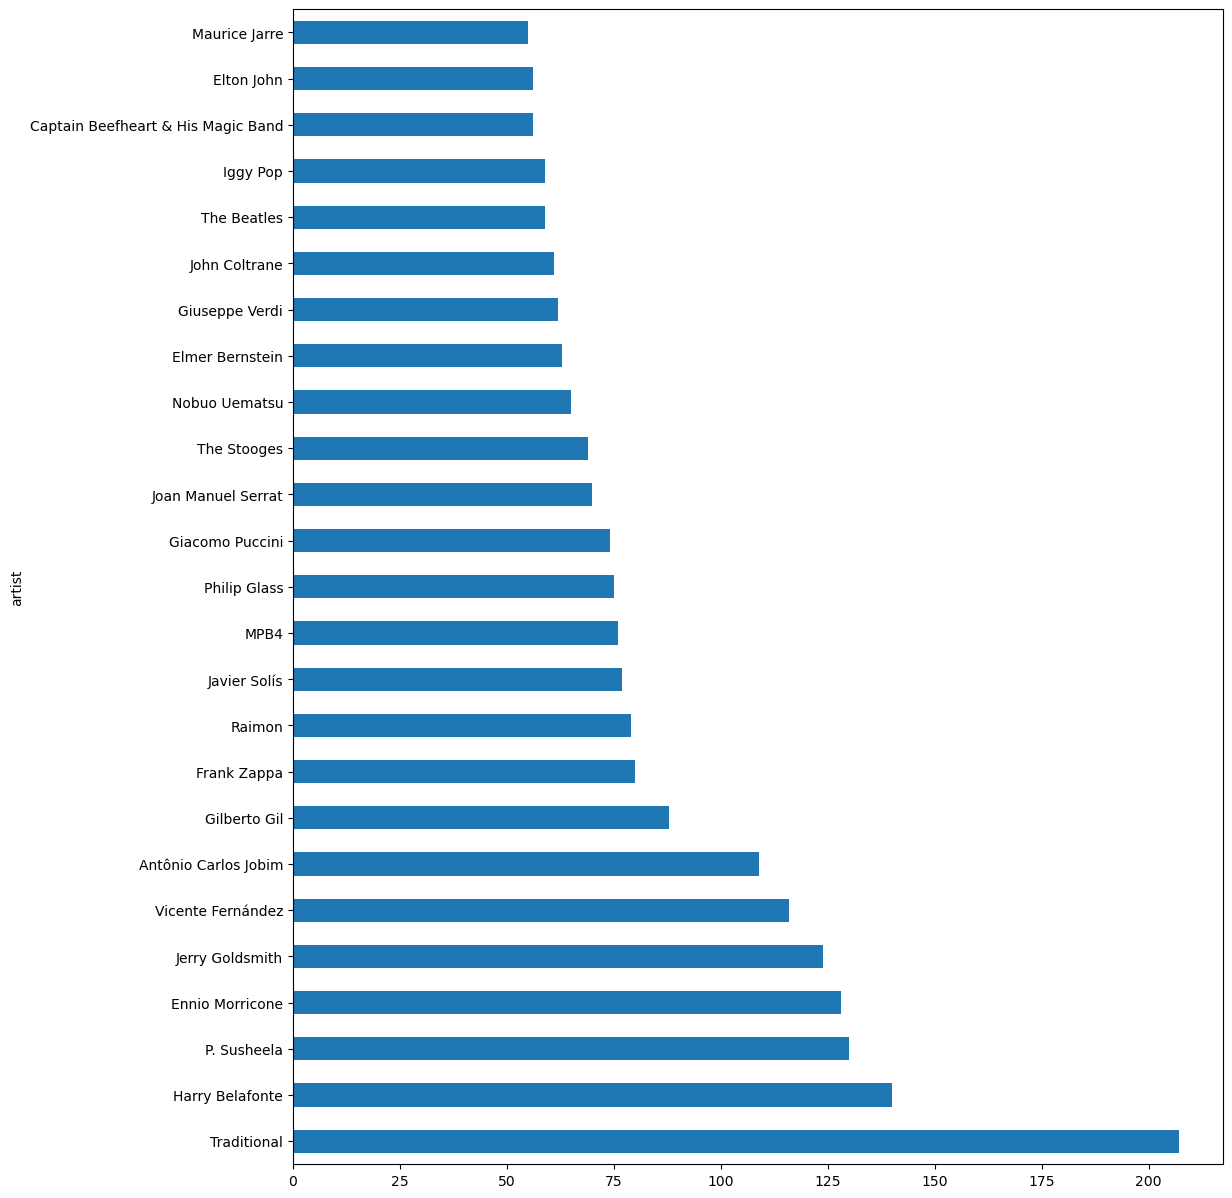

In [41]:
# Top 25 most popular artists

top_five_artists = df.groupby("artist").count().sort_values(by="track", ascending=False)['track'][:25]
fig, ax = plt.subplots(figsize=(12, 15))
top_five_artists.plot.barh(ax=ax)
plt.show()

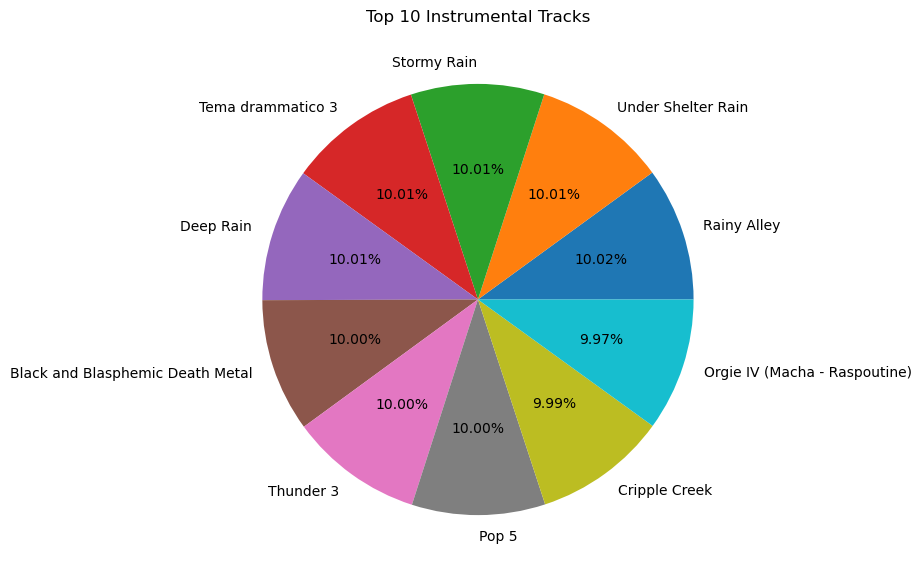

In [42]:
# Top 10 instrumental columns

top_10_instrumental_tracks=df[["instrumentalness","track","artist"]].sort_values(by="instrumentalness", ascending=False)[:10]
plt.figure(figsize=(12,7))
plt.pie(x="instrumentalness", data=top_10_instrumental_tracks,autopct="%1.2f%%",labels=top_10_instrumental_tracks.track)
plt.title("Top 10 Instrumental Tracks")
plt.show()

In [44]:
# We drop the redundant columns
df = df.drop(columns=['uri', 'track', 'artist'])

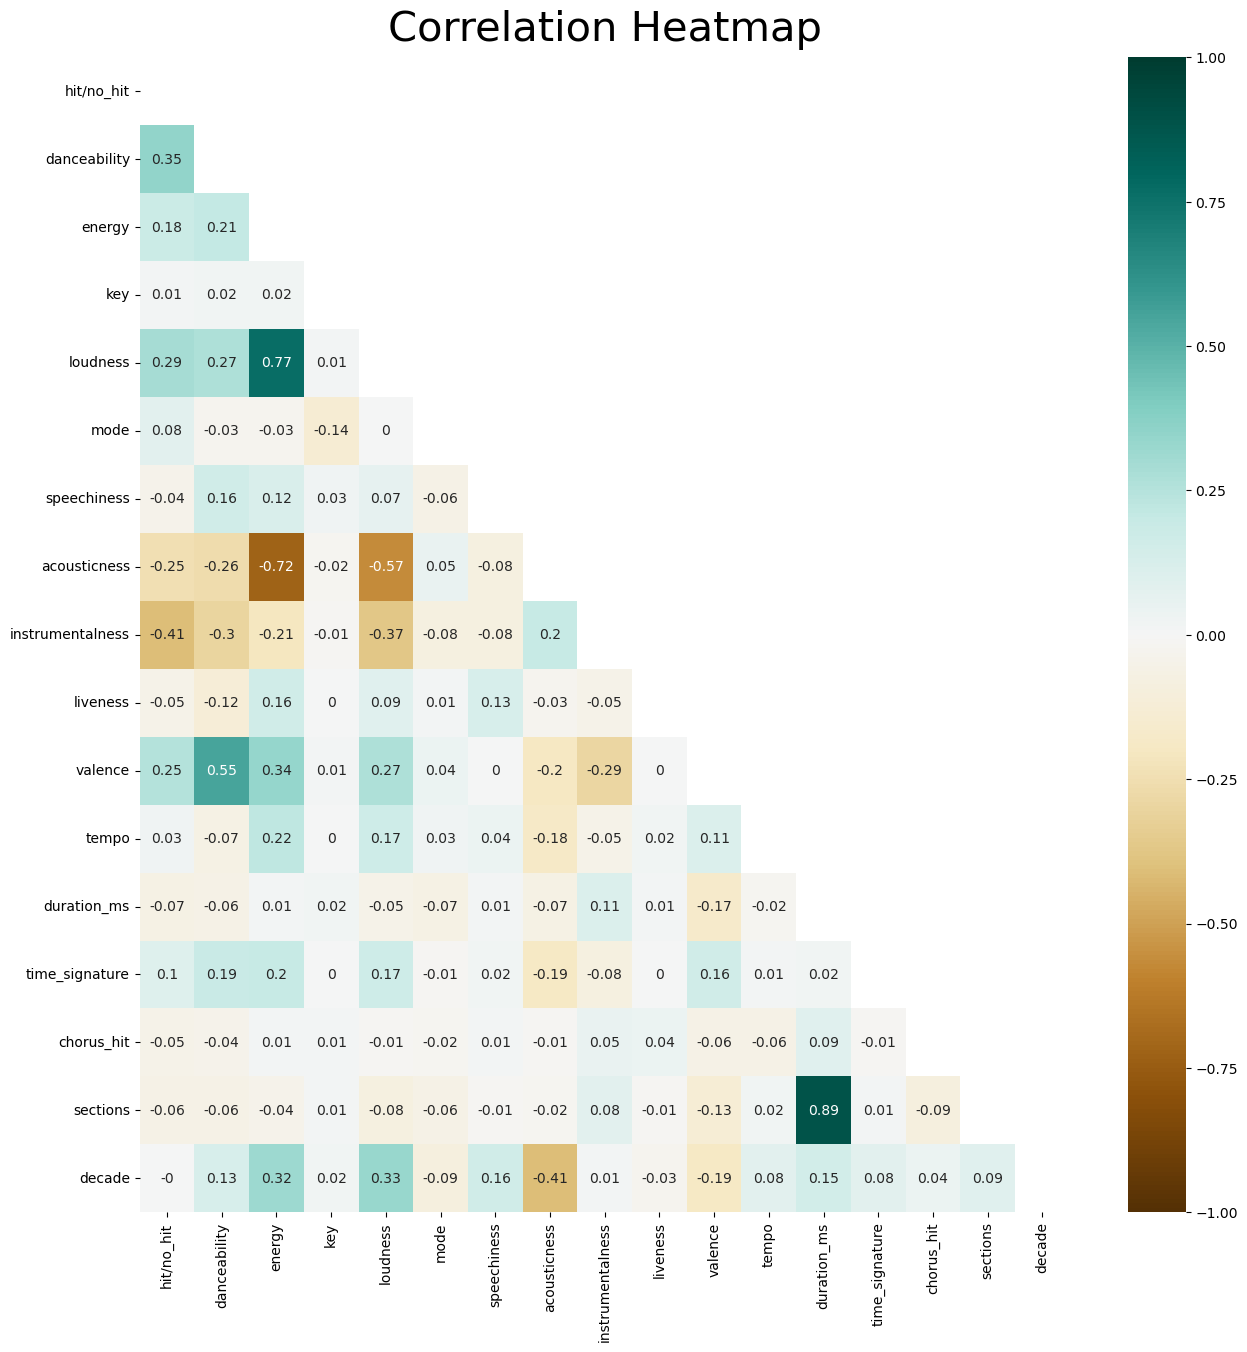

In [45]:
# Plotting the correlation matrix to check for feature multicolinearity
plt.figure(figsize=(15, 15))

corr = df.corr().round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))

heatmap = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG', annot_kws={"fontsize":10})
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':30}, pad=12)

plt.show()

In [46]:
# It seems that "sections" and "duration_ms" features are highly correlated. We will remove "sections" in order to avoid having redundant data in our model
df.drop(columns='sections', inplace=True, axis=1)

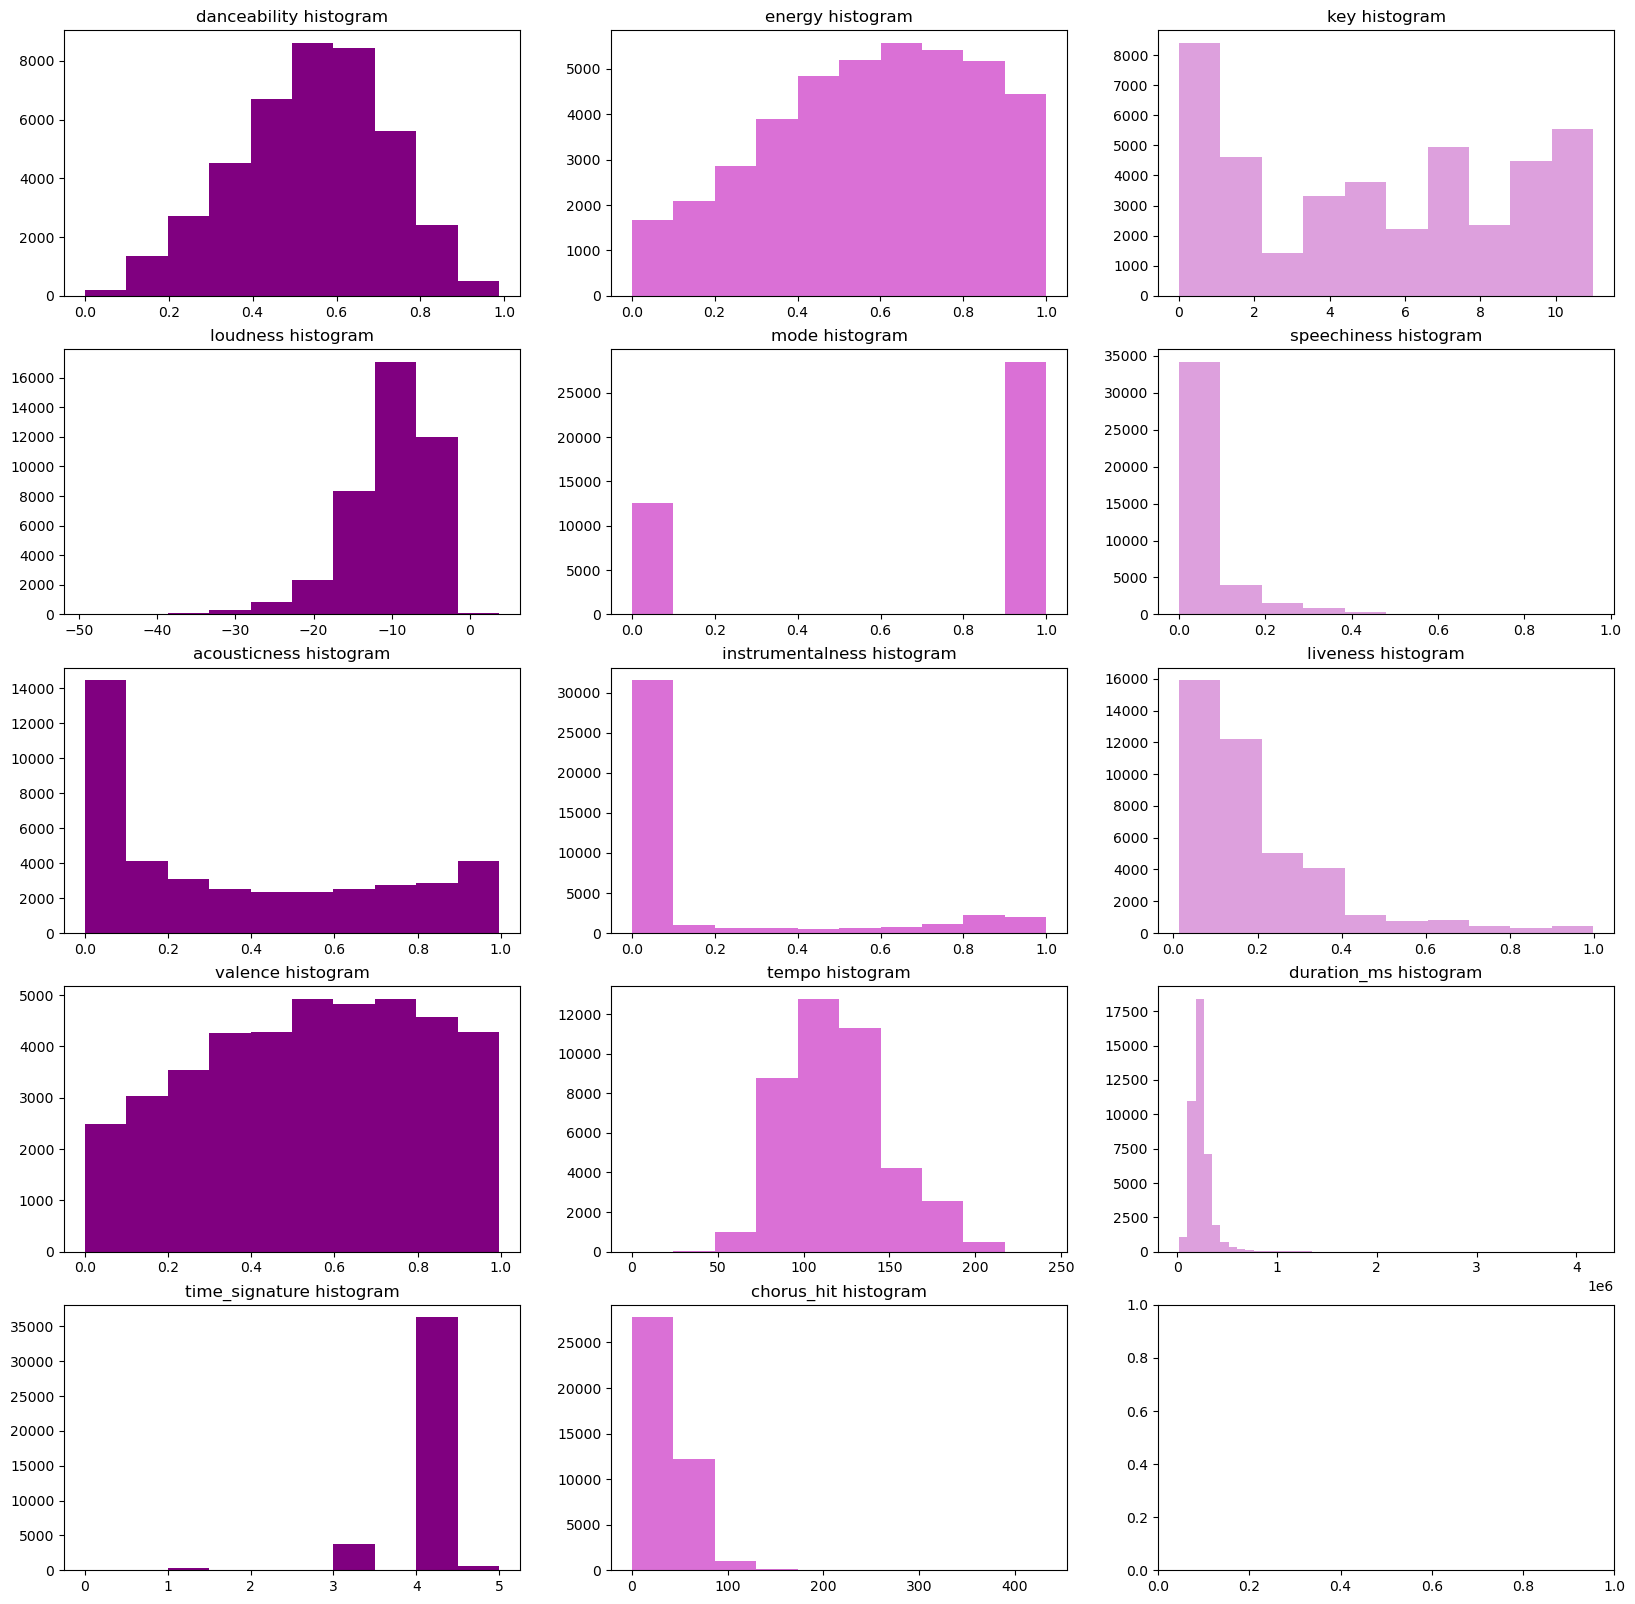

In [47]:
#create histograpms of all the variables to see distributions
fig, ax = plt.subplots(5,3, figsize=(20,20))

def hist_plot(row, column, variable, binsnum, color):
    ax[row, column].hist(df[variable], bins = binsnum, color = color)
    ax[row, column].set_title(variable + ' histogram')
    
hist_plot(0, 0, 'danceability', 10, 'purple')
hist_plot(0, 1, 'energy', 10, 'orchid')
hist_plot(0, 2, 'key', 10, 'plum')
hist_plot(1,0, 'loudness', 10, 'purple')
hist_plot(1,1, 'mode', 10, 'orchid')
hist_plot(1,2, 'speechiness', 10, 'plum')
hist_plot(2,0, 'acousticness', 10, 'purple')
hist_plot(2,1, 'instrumentalness', 10, 'orchid')
hist_plot(2,2, 'liveness', 10, 'plum')
hist_plot(3,0, 'valence', 10, 'purple')
hist_plot(3,1, 'tempo', 10, 'orchid')
hist_plot(3,2, 'duration_ms', 50, 'plum')
hist_plot(4,0, 'time_signature', 10, 'purple')
hist_plot(4,1, 'chorus_hit', 10, 'orchid')

plt.show()

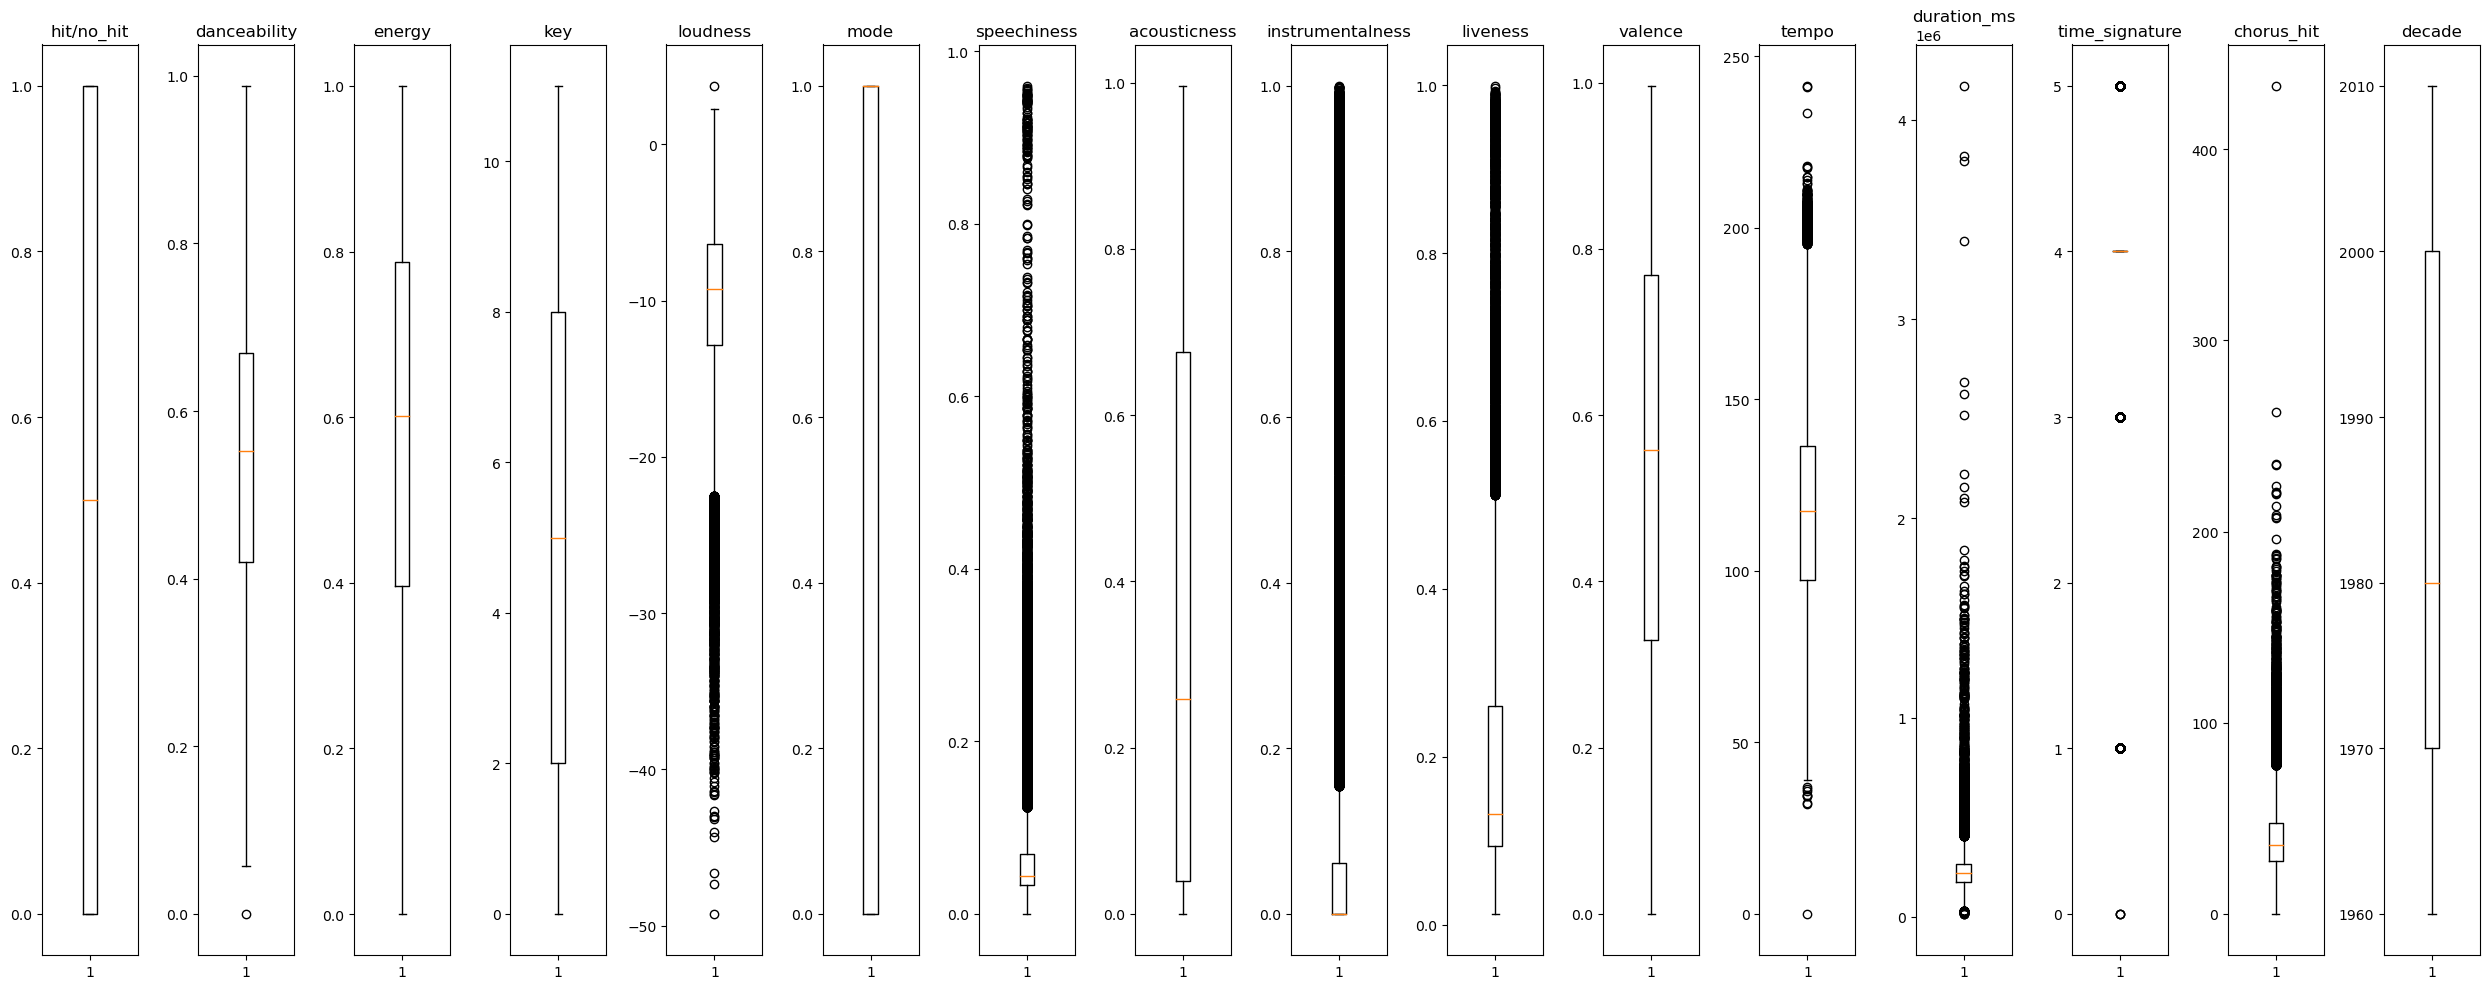

In [48]:
# Create subplots for each column in the dataframe to visualize and ration through outlier values in the data
fig, axs = plt.subplots(1, len(df.columns), figsize=(25, 10))

# Iterate over each column and create a boxplot
for i, column in enumerate(df.columns):
    axs[i].boxplot(df[column])
    axs[i].set_title(column)

plt.tight_layout()
plt.show()

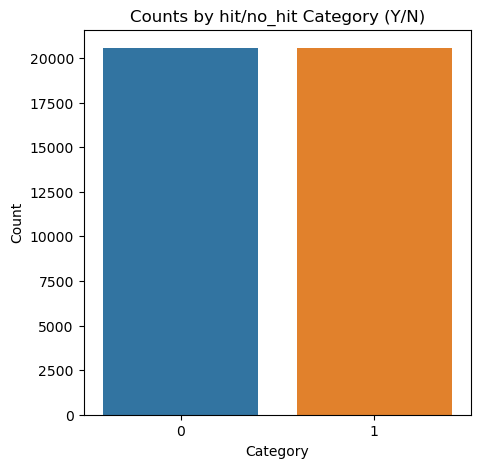

In [49]:
# Create the histogram to check for target feature class balance/imbalance
plt.figure(figsize=(5, 5), dpi=100)
sns.countplot(data=df, x='hit/no_hit')

# Add a title and labels
plt.title("Counts by hit/no_hit Category (Y/N)")
plt.xlabel("Category")
plt.ylabel("Count")

# Show the plot
plt.show()

In [50]:
# Split the data into train and validation sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=2023)
train_data, validation_data = train_test_split(train_data, test_size=0.25, random_state=2023)

In [51]:
#Save the files to our s3 bucket.

train_data.to_csv("train.csv", header=True, index=False)
validation_data.to_csv("validation.csv", header=True, index=False)
test_data.to_csv("test.csv", header=True, index=False)

s3 = boto3.resource("s3")
s3.Bucket(prefix).Object(os.path.join(prefix, "train/train.csv")).upload_file("train.csv")
s3.Bucket(prefix).Object(os.path.join(prefix, "validation/validation.csv")).upload_file("validation.csv")
s3.Bucket(prefix).Object(os.path.join(prefix, "test/test.csv")).upload_file("test.csv")